In [13]:
addprocs(2)

@everywhere begin
  using DiffEqMonteCarlo, StochasticDiffEq, DiffEqBase, DiffEqProblemLibrary, DiffEqNoiseProcess, Plots, LaTeXStrings, ParallelDataTransfer

  probs = Matrix{SDEProblem}(3,3)
  p1 = Vector{Any}(3)
  p2 = Vector{Any}(3)
  p3 = Vector{Any}(3)
  ## Problem 1
  prob = prob_sde_linear
  probs[1,1] = SDEProblem(prob.f,prob.g,prob.u0,prob.tspan,prob.p,noise=WienerProcess(0.0,0.0,0.0,rswm=RSWM(adaptivealg=:RSwM1)))
  probs[1,2] = SDEProblem(prob.f,prob.g,prob.u0,prob.tspan,prob.p,noise=WienerProcess(0.0,0.0,0.0,rswm=RSWM(adaptivealg=:RSwM2)))
  probs[1,3] = SDEProblem(prob.f,prob.g,prob.u0,prob.tspan,prob.p,noise=WienerProcess(0.0,0.0,0.0,rswm=RSWM(adaptivealg=:RSwM3)))
  ## Problem 2
  prob = prob_sde_wave
  probs[2,1] = SDEProblem(prob.f,prob.g,prob.u0,prob.tspan,prob.p,noise=WienerProcess(0.0,0.0,0.0,rswm=RSWM(adaptivealg=:RSwM1)))
  probs[2,2] = SDEProblem(prob.f,prob.g,prob.u0,prob.tspan,prob.p,noise=WienerProcess(0.0,0.0,0.0,rswm=RSWM(adaptivealg=:RSwM2)))
  probs[2,3] = SDEProblem(prob.f,prob.g,prob.u0,prob.tspan,prob.p,noise=WienerProcess(0.0,0.0,0.0,rswm=RSWM(adaptivealg=:RSwM3)))
  ## Problem 3
  prob = prob_sde_additive
  probs[3,1] = SDEProblem(prob.f,prob.g,prob.u0,prob.tspan,prob.p,noise=WienerProcess(0.0,0.0,0.0,rswm=RSWM(adaptivealg=:RSwM1)))
  probs[3,2] = SDEProblem(prob.f,prob.g,prob.u0,prob.tspan,prob.p,noise=WienerProcess(0.0,0.0,0.0,rswm=RSWM(adaptivealg=:RSwM2)))
  probs[3,3] = SDEProblem(prob.f,prob.g,prob.u0,prob.tspan,prob.p,noise=WienerProcess(0.0,0.0,0.0,rswm=RSWM(adaptivealg=:RSwM3)))
end

fullMeans = Vector{Array}(3)
fullMedians = Vector{Array}(3)
fullElapsed = Vector{Array}(3)
fullTols = Vector{Array}(3)
offset = 0

Ns = [17 23 17]

1×3 Array{Int64,2}:
 17  23  17

Timings are only valid if no workers die. Workers die if you run out of memory.

In [17]:
for k in 1:size(probs,1)
  println("Problem $k")
  ## Setup
  N = Ns[k]

  msims = Vector{Any}(N)
  elapsed = Array{Float64}(N,3)
  medians = Array{Float64}(N,3)
  means   = Array{Float64}(N,3)
  tols    = Array{Float64}(N,3)

  #Compile
  prob = probs[k,1]
  ParallelDataTransfer.sendto(workers(), prob=prob)
  monte_prob = MonteCarloProblem(prob)
  solve(monte_prob,SRIW1(),dt=1/2^(4),adaptive=true,num_monte=1000,abstol=2.0^(-1),reltol=0)

  println("RSwM1")
  for i=1+offset:N+offset
    tols[i-offset,1] = 2.0^(-i-1)
    msims[i-offset] = calculate_monte_errors(solve(monte_prob,SRIW1(),
                                            num_monte=1000,abstol=2.0^(-i-1),
                                            reltol=0,force_dtmin=true))
    elapsed[i-offset,1] = msims[i-offset].elapsedTime
    medians[i-offset,1] = msims[i-offset].error_medians[:final]
    means[i-offset,1]   = msims[i-offset].error_means[:final]
  end

  println("RSwM2")
  prob = probs[k,2]
  ParallelDataTransfer.sendto(workers(), prob=prob)
  monte_prob = MonteCarloProblem(prob)
  solve(monte_prob,SRIW1(),dt=1/2^(4),adaptive=true,num_monte=1000,abstol=2.0^(-1),reltol=0)

  for i=1+offset:N+offset
    tols[i-offset,2] = 2.0^(-i-1)
    msims[i-offset] = calculate_monte_errors(solve(monte_prob,SRIW1(),
                                            num_monte=1000,abstol=2.0^(-i-1),
                                            reltol=0,force_dtmin=true))
    elapsed[i-offset,2] = msims[i-offset].elapsedTime
    medians[i-offset,2] = msims[i-offset].error_medians[:final]
    means[i-offset,2]   = msims[i-offset].error_means[:final]
  end

  println("RSwM3")
  prob = probs[k,3]
  ParallelDataTransfer.sendto(workers(), prob=prob)
  monte_prob = MonteCarloProblem(prob)
  solve(monte_prob,SRIW1(),dt=1/2^(4),adaptive=true,num_monte=1000,abstol=2.0^(-1),reltol=0)

  for i=1+offset:N+offset
    tols[i-offset,3] = 2.0^(-i-1)
        msims[i-offset] = calculate_monte_errors(solve(monte_prob,SRIW1(),
                                    adaptive=true,num_monte=1000,abstol=2.0^(-i-1),
                                    reltol=0,force_dtmin=true))
    elapsed[i-offset,3] = msims[i-offset].elapsedTime
    medians[i-offset,3] = msims[i-offset].error_medians[:final]
    means[i-offset,3]   = msims[i-offset].error_means[:final]
  end

  fullMeans[k] = means
  fullMedians[k] =medians
  fullElapsed[k] = elapsed
  fullTols[k] = tols
end


Problem 1
RSwM1
RSwM2
RSwM3
Problem 2
RSwM1
RSwM2
RSwM3
Problem 3
RSwM1
RSwM2
RSwM3


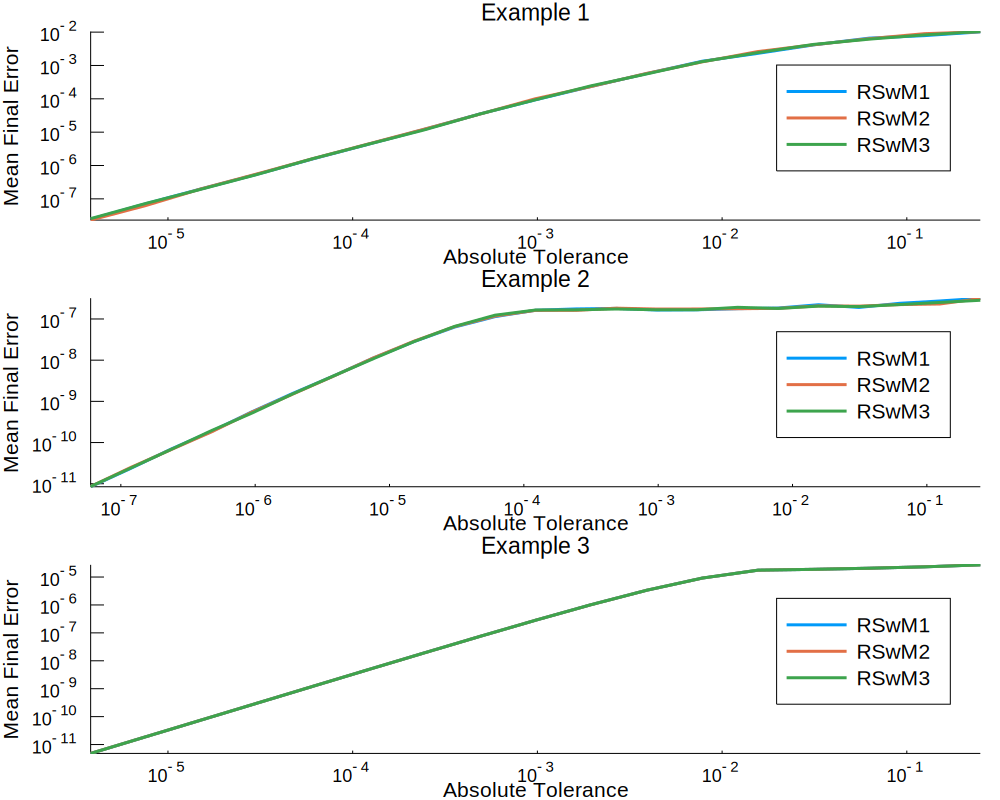

In [30]:
gr(fmt=:svg)
lw=3
leg=String["RSwM1","RSwM2","RSwM3"]

titleFontSize = 16
guideFontSize = 14
legendFontSize= 14
tickFontSize  = 12

for k in 1:size(probs,1)
  p1[k] = Plots.plot(fullTols[k],fullMeans[k],xscale=:log10,yscale=:log10,  xguide="Absolute Tolerance",yguide="Mean Final Error",title="Example $k"  ,linewidth=lw,grid=false,lab=leg,titlefont=font(titleFontSize),legendfont=font(legendFontSize),tickfont=font(tickFontSize),guidefont=font(guideFontSize))
  p2[k] = Plots.plot(fullTols[k],fullMedians[k],xscale=:log10,yscale=:log10,xguide="Absolute Tolerance",yguide="Median Final Error",title="Example $k",linewidth=lw,grid=false,lab=leg,titlefont=font(titleFontSize),legendfont=font(legendFontSize),tickfont=font(tickFontSize),guidefont=font(guideFontSize))
  p3[k] = Plots.plot(fullTols[k],fullElapsed[k],xscale=:log10,yscale=:log10,xguide="Absolute Tolerance",yguide="Elapsed Time",title="Example $k"      ,linewidth=lw,grid=false,lab=leg,titlefont=font(titleFontSize),legendfont=font(legendFontSize),tickfont=font(tickFontSize),guidefont=font(guideFontSize))
end

Plots.plot!(p1[1])
Plots.plot(p1[1],p1[2],p1[3],layout=(3,1),size=(1000,800))


In [19]:
#savefig("meanvstol.png")
#savefig("meanvstol.pdf")

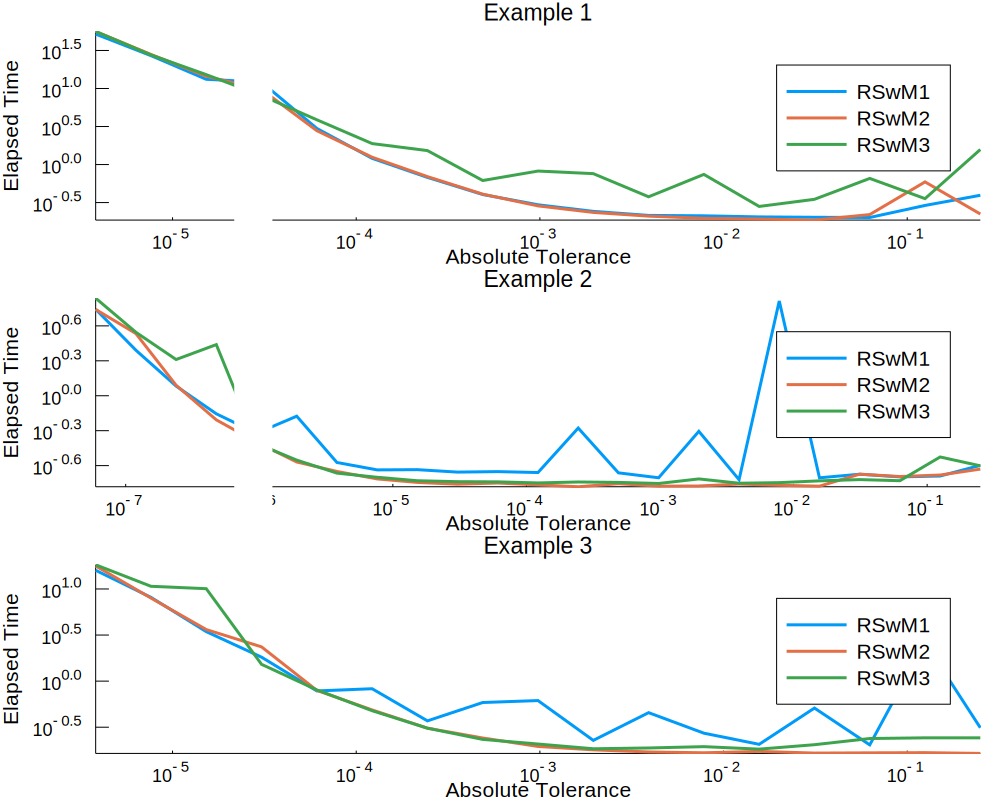

In [31]:
plot(p3[1],p3[2],p3[3],layout=(3,1),size=(1000,800))
#savefig("timevstol.png")
#savefig("timevstol.pdf")

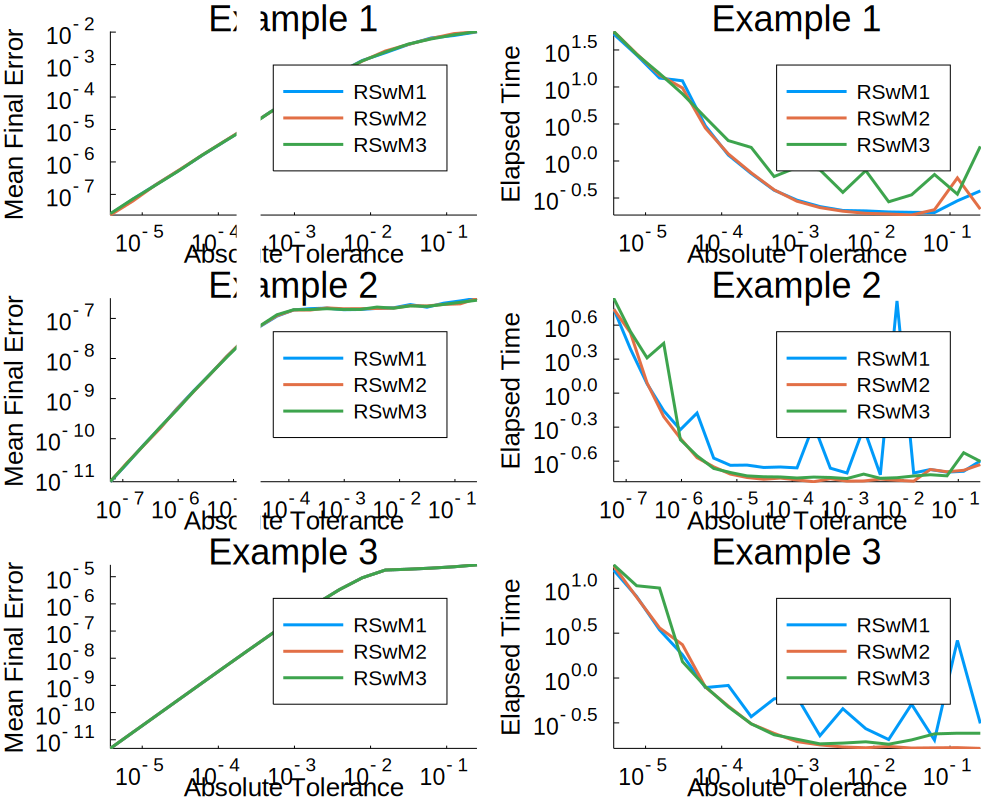

In [21]:
plot(p1[1],p3[1],p1[2],p3[2],p1[3],p3[3],layout=(3,2),size=(1000,800))